# Initialization. Load previous state. Load modules

In [1]:
import dill
# Restore the entire session
#dill.load_session('Multiple_random_finetune_ptr.db')

In [2]:
#check last result on disk
#dir()

In [3]:
from tqdm import tqdm
import os
import random
import time

In [4]:
import json

import pandas as pd
import numpy as np
import numpy as cp
#import cupy as cp

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tabpfn import TabPFNRegressor
#from xgboost import XGBRegressor
#from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
#from sklearn.svm import SVR

from finetuning_scripts.finetune_tabpfn_main import fine_tune_tabpfn
from sklearn.metrics import log_loss


In [5]:
def finetunemymodel(X, y, param_grid , verbose):

    save_path_to_fine_tuned_model = param_grid.get("model_path")
    path_to_base_model = "auto"  # Valor por defecto

#    # Verifica si el archivo existe
#    if os.path.exists(save_path_to_fine_tuned_model):
#        path_to_base_model = save_path_to_fine_tuned_model
#        print(f"Cargando modelo base desde: {path_to_base_model}")
#    else:
#        print("No se encontró el modelo pre-entrenado. Usando 'auto' para el modelo base.")
    
    fine_tune_tabpfn(
        path_to_base_model=path_to_base_model,
        save_path_to_fine_tuned_model=save_path_to_fine_tuned_model,
        # Finetuning HPs
        time_limit=60,
        finetuning_config={"learning_rate": 0.0000002, "batch_size": 5},
        validation_metric="mse",
        X_train=pd.DataFrame(X),
        y_train=pd.Series(y),
        categorical_features_index=None,
        device=param_grid.get('device'), 
        task_type="regression",
        # Optional
        show_training_curve=True,  # Shows a final report after finetuning.
        logger_level=0,  # Shows all logs, higher values shows less
        use_wandb=False,  # Init wandb yourself, and set to True
    )


# Load datasets froms json file

In [6]:
# Load data from JSON
with open('data_reg.json', 'r') as json_file:
    loaded_datasets = json.load(json_file)


# Train methods

## All datasets

In [7]:
def predict_reg_by_label(IDs, y, X, regressor, param_grid={}, cv=5, gpu=False, verbose=True):
    """
    Calculates predictions for test sets, each with a unique label in IDs, and selects the best parameters using GridSearchCV.

    Args:
        IDs: A pandas Series containing labels.
        y: A pandas Series or numpy array containing target labels.
        X: A pandas DataFrame or numpy array containing features.
        regressor: A scikit-learn regressor class.
        param_grid: A dictionary specifying parameter options for GridSearchCV.
        cv: Number of folds for cross-validation.
        verbose: If True, prints progress and metrics.

    Returns:
        predictions: Predictions for y as test sets.
        arv.
        best_params_per_label: Dictionary with the best parameters for each label.
    """
    unique_labels = IDs.unique()
    best_params_per_label = {}
    
    # Ensure X and y are numpy arrays for compatibility
    #if not isinstance(X, np.ndarray):
    #    X = X.to_numpy()
    #if not isinstance(y, np.ndarray):
    #    y = y.to_numpy()

    predictions = y[:]*0

    for label in unique_labels:
        mask = (IDs == label)
        X_train, X_test = X[~mask], X[mask]
        y_train, y_test = y[~mask], y[mask]

        # Use GridSearchCV to find the best parameters
        if cv>1:
            grid_search = GridSearchCV(
                estimator=regressor(),
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=cv,
                verbose=verbose
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            # Store the best parameters
            best_params_per_label[label] = grid_search.best_params_
            
        else:
            #fine tune tabPFN if selected
            if regressor is TabPFNRegressor and param_grid.get("model_path","auto") != "auto":
                finetunemymodel(X_train,y_train,param_grid,verbose)

            best_model = regressor(**param_grid)
            best_model.fit(X_train, y_train)
            best_params_per_label[label] = param_grid
                            
        # Predict on the test set
        predictions[mask] = best_model.predict(X_test)
        
        if verbose:
            print(f"Label: {label}, Best Params: {best_params_per_label[label]}")
            print(f"Test Set MSE for label {label}: {round(mean_squared_error(y_test, predictions[mask]), 4)}")

    # Final metrics
    final_mse = mean_squared_error(y, predictions)
    final_arv = final_mse / np.var(y)
    
    if verbose:
        print(f"\nOverall Mean Squared Error: {round(final_mse, 4)}")
        print(f"Overall Adjusted Residual Variance (ARV): {round(final_arv, 4)}")

    return predictions, final_arv, best_params_per_label

Fine-tuning Steps:   0%| | 16/10000 [00:54<10:07:11,  3.65s/it, Best Val. Loss=4.46, Best Val. Score=-4.46, Tr
/home/granitto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


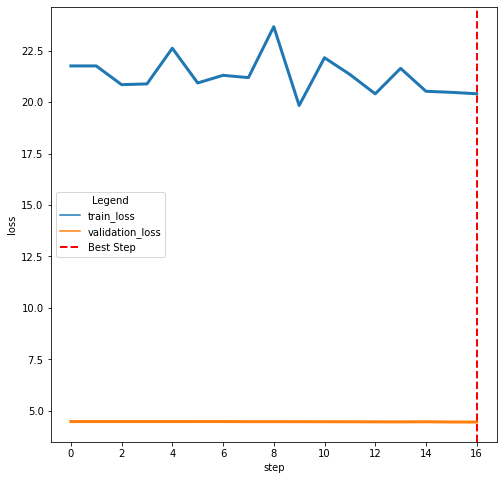

Fine-tuning Steps:   0%| | 17/10000 [00:56<9:46:52,  3.53s/it, Best Val. Loss=5.57, Best Val. Score=-5.57, Tra


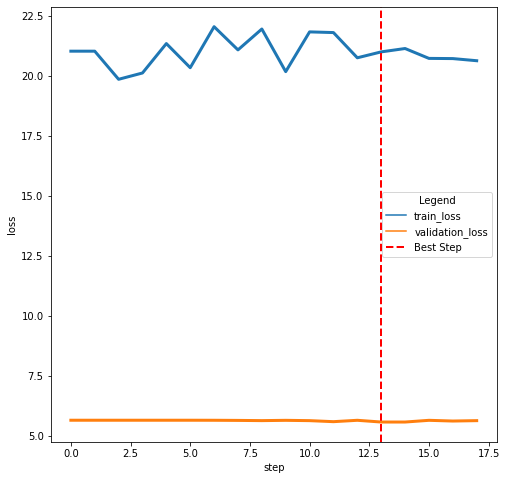

Fine-tuning Steps:   0%| | 19/10000 [00:58<8:56:33,  3.23s/it, Best Val. Loss=0.115, Best Val. Score=-0.115, T


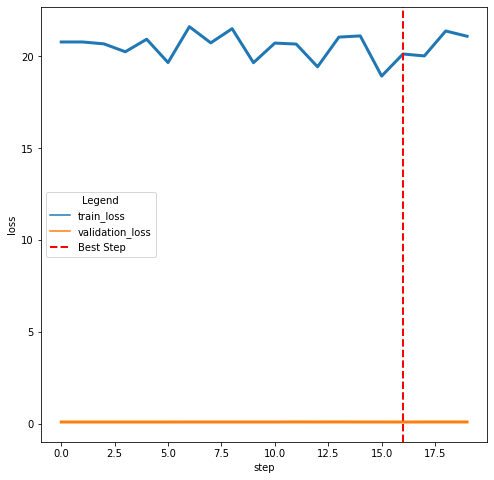

Noc_O-finetune_tabPFN: 0.2582
Noc_O-tabPFN: 0.2569


Fine-tuning Steps:   0%| | 12/10000 [00:53<13:32:35,  4.88s/it, Best Val. Loss=5.43, Best Val. Score=-5.43, Tr


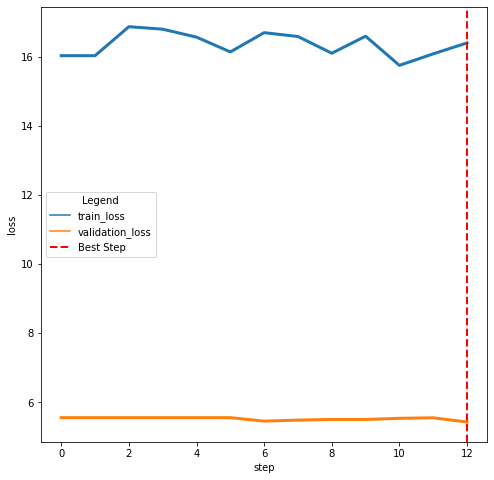

Fine-tuning Steps:   0%| | 13/10000 [00:57<13:15:10,  4.78s/it, Best Val. Loss=0.246, Best Val. Score=-0.246, 


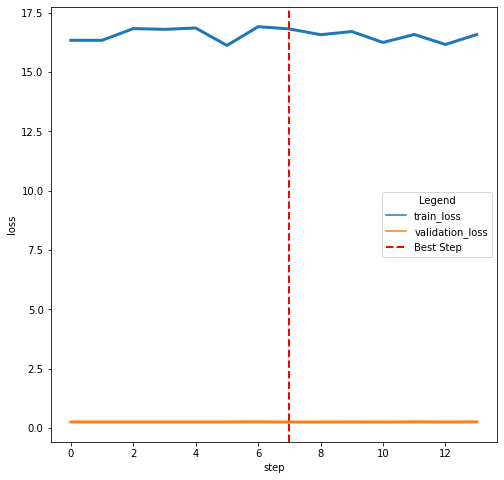

Fine-tuning Steps:   0%| | 12/10000 [00:53<13:35:48,  4.90s/it, Best Val. Loss=0.226, Best Val. Score=-0.226, 


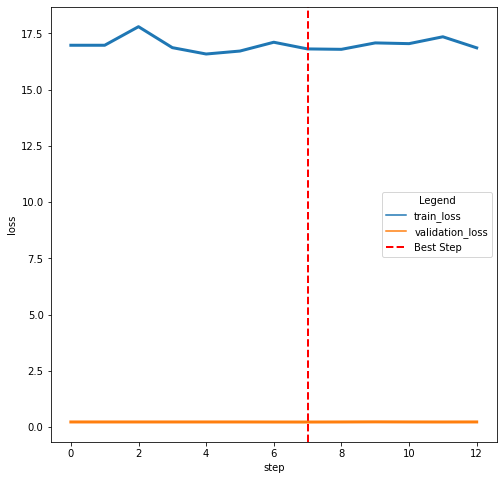

Fine-tuning Steps:   0%| | 13/10000 [00:57<13:18:56,  4.80s/it, Best Val. Loss=0.361, Best Val. Score=-0.361, 


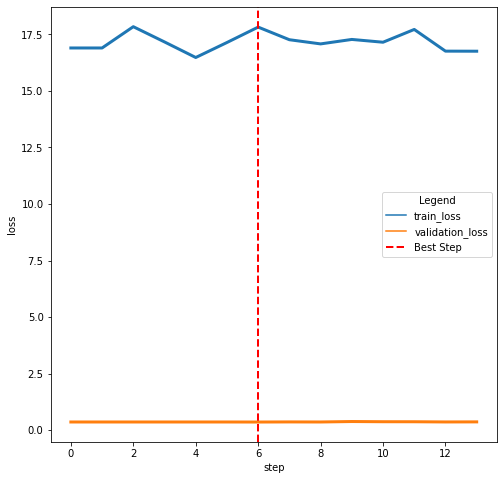

Fine-tuning Steps:   0%| | 13/10000 [00:57<13:15:17,  4.78s/it, Best Val. Loss=0.19, Best Val. Score=-0.19, Tr


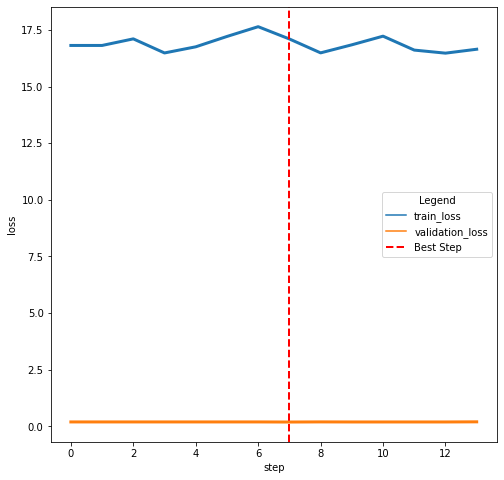

Fine-tuning Steps:   0%| | 13/10000 [00:57<13:19:23,  4.80s/it, Best Val. Loss=0.533, Best Val. Score=-0.533, 


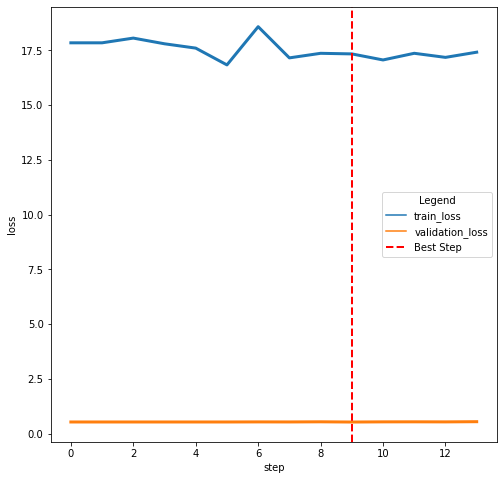

Fine-tuning Steps:   0%| | 13/10000 [00:57<13:19:41,  4.80s/it, Best Val. Loss=0.442, Best Val. Score=-0.442, 


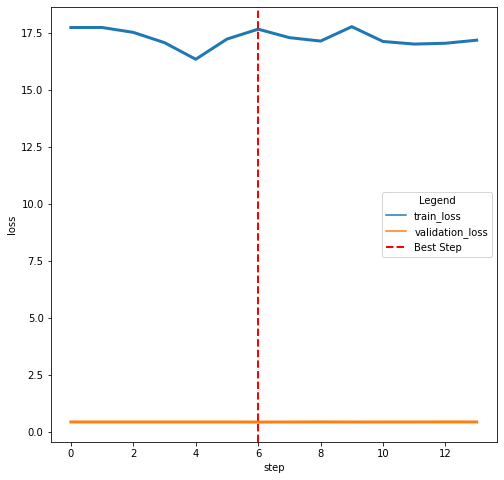

Fine-tuning Steps:   0%| | 12/10000 [00:53<13:36:31,  4.90s/it, Best Val. Loss=0.283, Best Val. Score=-0.283, 


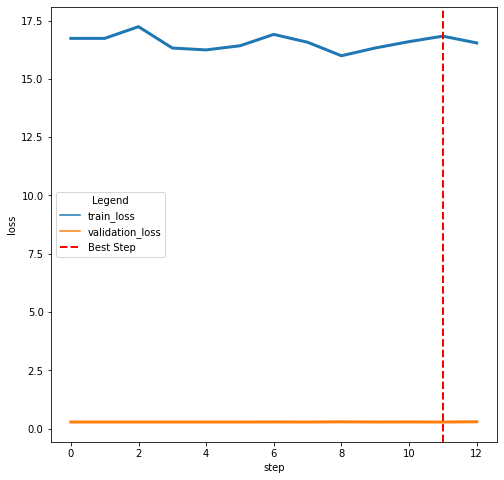

Fine-tuning Steps:   0%| | 13/10000 [00:56<13:07:20,  4.73s/it, Best Val. Loss=1.43, Best Val. Score=-1.43, Tr


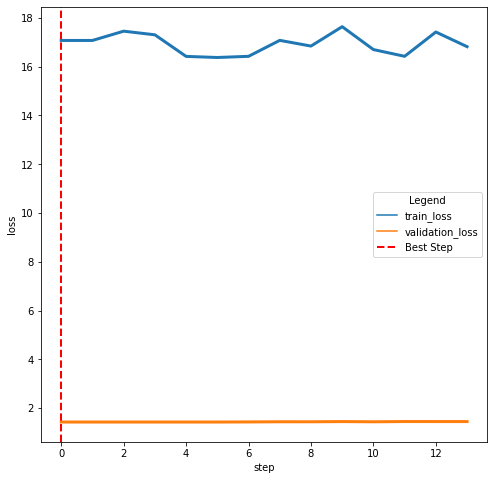

Fine-tuning Steps:   0%| | 12/10000 [00:54<13:44:37,  4.95s/it, Best Val. Loss=0.102, Best Val. Score=-0.102, 


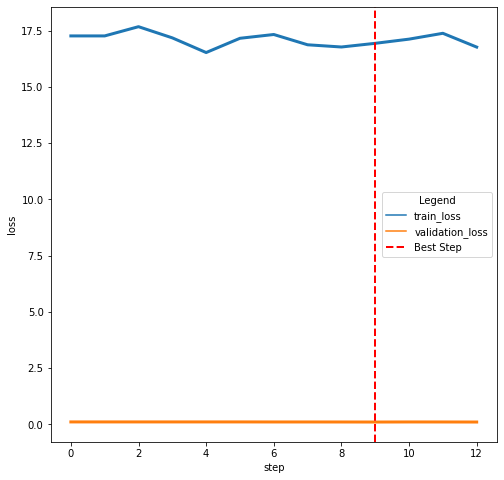

Fine-tuning Steps:   0%| | 13/10000 [00:57<13:18:04,  4.79s/it, Best Val. Loss=0.0779, Best Val. Score=-0.0779


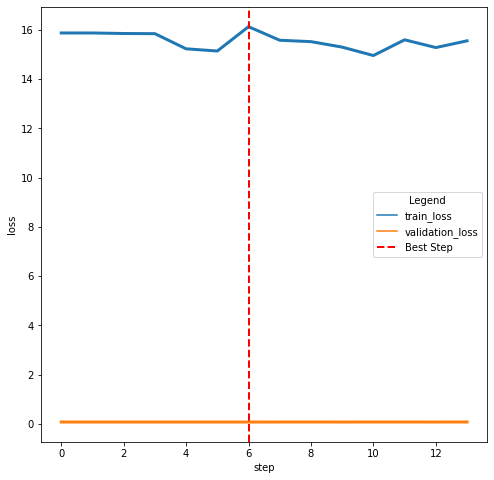

Fine-tuning Steps:   0%| | 13/10000 [00:56<13:03:20,  4.71s/it, Best Val. Loss=0.282, Best Val. Score=-0.282, 


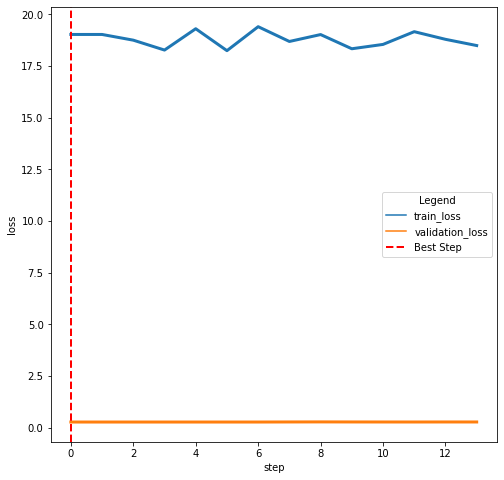

Fine-tuning Steps:   0%| | 12/10000 [00:53<13:36:21,  4.90s/it, Best Val. Loss=0.0926, Best Val. Score=-0.0926


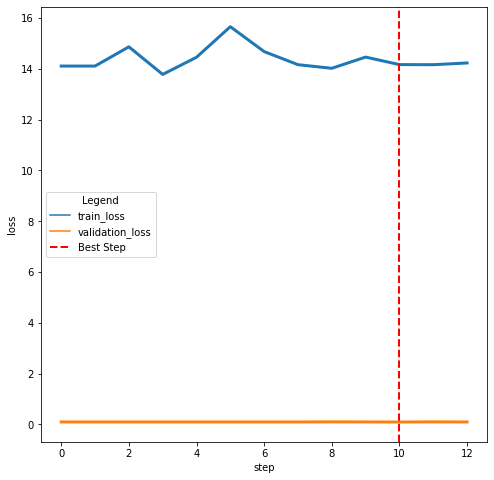

Fine-tuning Steps:   0%| | 12/10000 [00:54<13:50:04,  4.99s/it, Best Val. Loss=0.232, Best Val. Score=-0.232, 


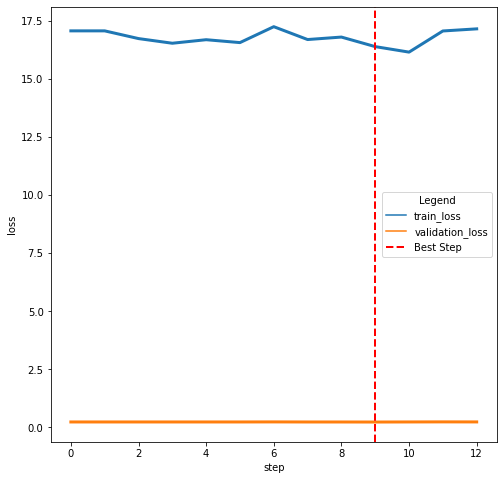

/home/granitto/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/home/granitto/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/home/granitto/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/home/granitto/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
Fine-tuning Steps:   0%| | 12/10000 [00:53<13:33:19,  4.89s/it, Best Val. Loss=0.287, Best Val. Score=-0.287, 


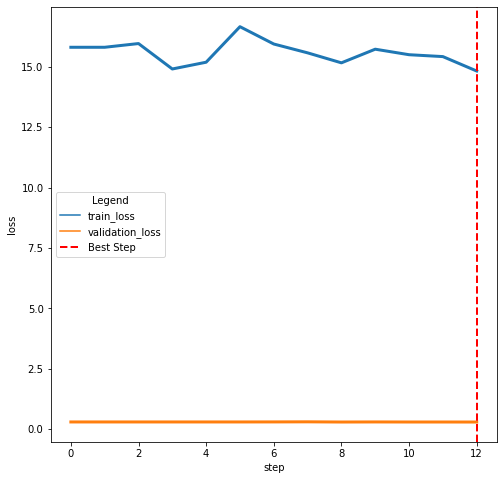

Fine-tuning Steps:   0%| | 12/10000 [00:54<13:49:34,  4.98s/it, Best Val. Loss=0.207, Best Val. Score=-0.207, 


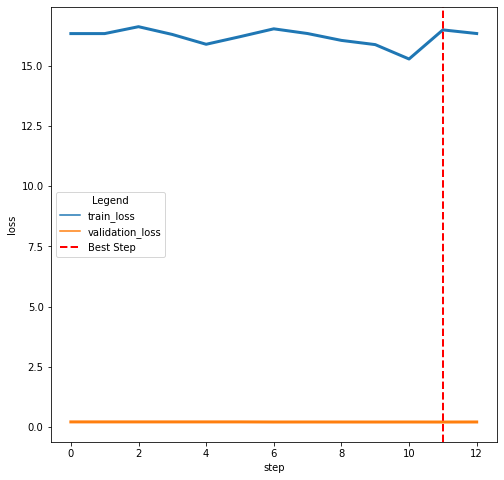

Fine-tuning Steps:   0%| | 12/10000 [00:54<13:37:51,  4.91s/it, Best Val. Loss=0.159, Best Val. Score=-0.159, 


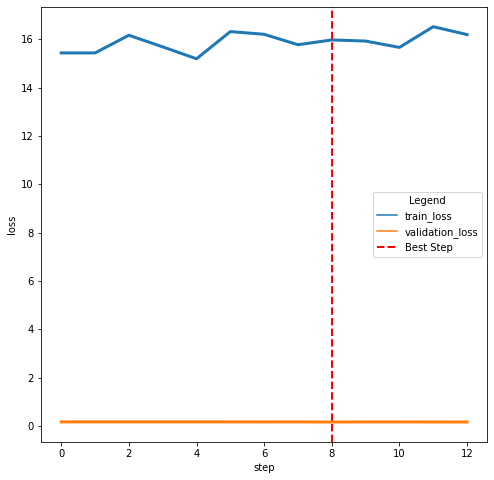

Fine-tuning Steps:   0%| | 13/10000 [00:57<13:19:14,  4.80s/it, Best Val. Loss=0.278, Best Val. Score=-0.278, 


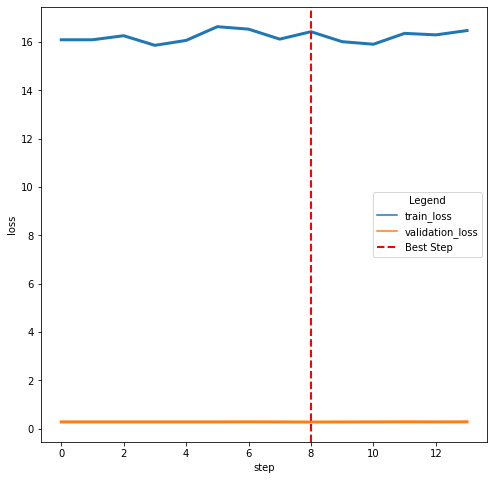

Fine-tuning Steps:   0%| | 12/10000 [00:53<13:34:56,  4.90s/it, Best Val. Loss=0.408, Best Val. Score=-0.408, 


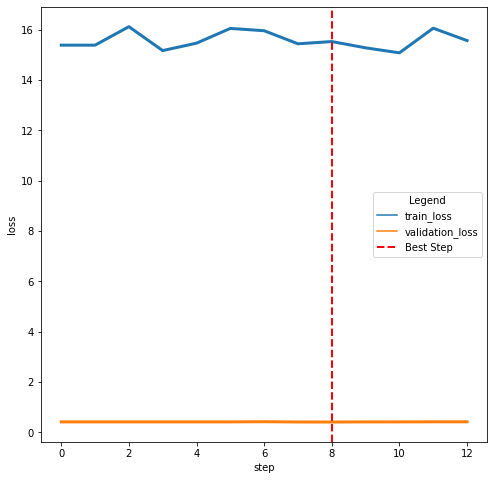

Fine-tuning Steps:   0%| | 12/10000 [00:54<13:37:27,  4.91s/it, Best Val. Loss=0.303, Best Val. Score=-0.303, 


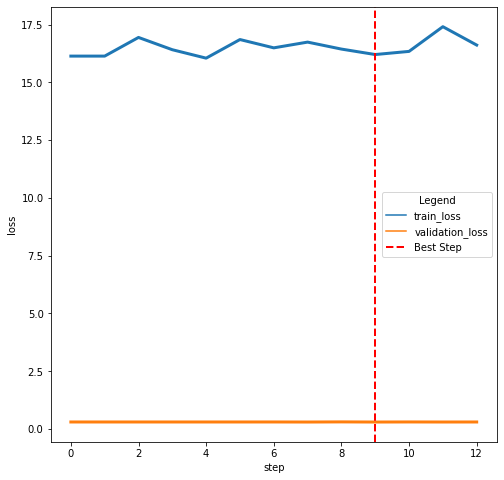

Noc_3T-finetune_tabPFN: 0.0832


/home/granitto/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/home/granitto/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/home/granitto/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
/home/granitto/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3416: RuntimeWarning: overflow encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


Noc_3T-tabPFN: 0.0834


In [9]:
datasets = ["Gum1b","Gum2b","Gum3b","Gum1s","Gum2s","Gum3s","Noc_S","Noc_O","Noc_3T"]
datasets = ["Noc_O","Noc_3T"]

# Dictionary to store results
results = {dataset: {} for dataset in datasets}

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# Loop through datasets
for dataset in datasets:
    this_data = loaded_datasets[dataset]
    # Define model parameters
    models = {
      "finetune_tabPFN": {
        "regressor": TabPFNRegressor,
        "param_grid": {
            'model_path': f'./{dataset}.ft.ckpt',
            'device': 'cuda',
            'ignore_pretraining_limits':True
        },
        "cv": 0,
        "gpu": False
      },
        "tabPFN": {
        "regressor": TabPFNRegressor,
        "param_grid": {
            'model_path': 'auto',
            'device': 'cuda',
            'ignore_pretraining_limits':True
        },
        "cv": 0,
        "gpu": False
      }
    }

    
    IDs = pd.Series(this_data["IDs"])
    y = np.array(this_data["y"])
    #z-score
    X = pd.DataFrame(this_data["X"])
    columns_to_keep = X.columns
    X = pd.DataFrame(scaler.fit_transform(X) , columns=columns_to_keep)

    for model_name, model_info in models.items():
        predict = predict_reg_by_label(
            cv=model_info["cv"], 
            gpu=model_info["gpu"], 
            IDs=IDs, 
            y=y, 
            X=X, 
            regressor=model_info["regressor"], 
            param_grid=model_info["param_grid"], 
            verbose=False
        )
        results[dataset][model_name] = predict
        print(f"{dataset}-{model_name}: {round(predict[1],4)}")
                

In [10]:
dill.dump_session('finetune_reg.db')

In [11]:
# Print header
print("Dataset".ljust(12) + " | " + " | ".join(model_name.ljust(15) for model_name in models))

# Print separator line
print("-" * (12 + 3 + len(models) * 18))

# Print results
for dataset in datasets:
    result_line = f"{dataset.ljust(12)} | " + " | ".join(f"{round(results[dataset][model_name][1],4):<15}" for model_name in models)
    print(result_line)


Dataset      | finetune_tabPFN | tabPFN         
---------------------------------------------------
Noc_O        | 0.2582          | 0.2569         
Noc_3T       | 0.0832          | 0.0834         
